<a href="https://colab.research.google.com/github/jakubgolab/Machine-Learning/blob/main/facemask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Face Mask Detector


Author: Jakub Gołąb <br>
Dataset used for model training consists of pictures scraped from the google images as well as photos from kaggle dataset: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection

The aim of this project is to build and train model capable of recognizing wheter a face mask is put on or not. To do so, I will experimentally create a simple Convolutional Neural Network that can perform a binary classification. Later on, I will make use of VGG16 architecture and using transfer learning I will adapt this model to recognize face mask. At the end I will compare overall performance of these two models.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import os
import shutil

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

##Exploratory Data Analysis

Dataset consists of two classes:
- with face mask
- without face mask

Each class should have around the same number of pictures. 

In [2]:
base_dir = "/content/drive/MyDrive/data"

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

print("With mask train size: ", len(os.listdir(os.path.join(train_dir, "with_mask"))))
print("Without mask train size: ", len(os.listdir(os.path.join(train_dir, "without_mask"))))

print("With mask test size: ", len(os.listdir(os.path.join(test_dir, "with_mask"))))
print("Without mask test size: ", len(os.listdir(os.path.join(test_dir, "without_mask"))))

With mask train size:  154
Without mask train size:  160
With mask test size:  51
Without mask test size:  51


In [3]:
train_with_mask_dir = os.path.join(train_dir, "with_mask")
train_without_mask_dir = os.path.join(train_dir, "without_mask")

test_with_mask_dir = os.path.join(test_dir, "with_mask")
test_without_mask_dir = os.path.join(test_dir, "without_mask")

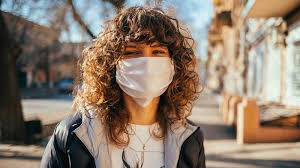

In [4]:
sample_img = image.load_img(os.path.join(train_with_mask_dir, os.listdir(train_with_mask_dir)[125]))
sample_img

In [5]:
train_augmentation = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest"
)

test_augmentation = ImageDataGenerator(
    rescale = 1./255.
)


train_generator = train_augmentation.flow_from_directory(
    directory = train_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = "binary"
)

test_generator = test_augmentation.flow_from_directory(
    directory = test_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = "binary"
)

Found 314 images belonging to 2 classes.
Found 102 images belonging to 2 classes.


##Image Generator

Sample shape:  (1, 168, 300, 3)


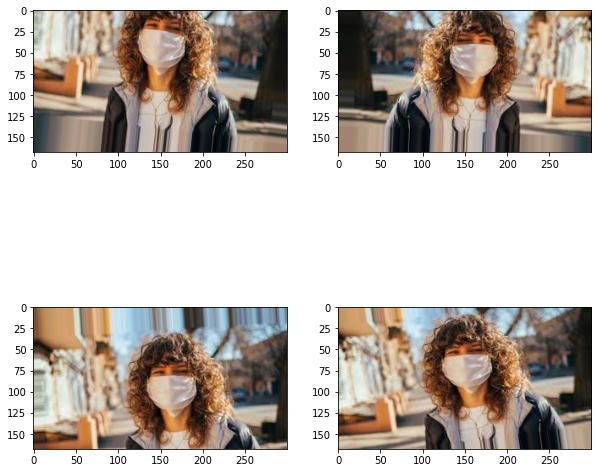

In [6]:
sample = image.load_img(os.path.join(train_with_mask_dir, os.listdir(train_with_mask_dir)[125]))
sample_arr = image.img_to_array(sample)
sample_arr = np.expand_dims(sample_arr, 0)
print("Sample shape: ", sample_arr.shape)

it = train_augmentation.flow(sample_arr, batch_size=1)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
  for j in range(2):
    generated_image = it.next()[0]
    axes[i, j].imshow(generated_image)
plt.show()

##Convolutional Neural Network Architecture

In [7]:
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [8]:
model.compile(
    optimizer = optimizers.RMSprop(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [9]:
train_size = len(os.listdir(os.path.join(train_dir, "with_mask"))) + len(os.listdir(os.path.join(train_dir, "without_mask")))
test_size = len(os.listdir(os.path.join(test_dir, "with_mask"))) + len(os.listdir(os.path.join(test_dir, "without_mask")))

print("Train size: ", train_size)
print("Test size: ", test_size)

Train size:  314
Test size:  102


##Model Training

In [ ]:
batch_size = 30
steps_per_epoch = train_size // batch_size
test_steps = test_size // batch_size

history = model.fit_generator(
    generator = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = 30,
    validation_data = test_generator,
    validation_steps = test_steps
)

<ipython-input-23-f05adeb4444a>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
10/10 [==============================] - 43s 4s/step - loss: 0.7858 - accuracy: 0.4968 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/30
10/10 [==============================] - 13s 1s/step - loss: 0.6945 - accuracy: 0.4841 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 3/30
10/10 [==============================] - 13s 1s/step - loss: 0.6934 - accuracy: 0.4745 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 4/30
10/10 [==============================] - 13s 1s/step - loss: 0.6923 - accuracy: 0.5191 - val_loss: 0.6901 - val_accuracy: 0.5625
Epoch 5/30
10/10 [==============================] - 13s 1s/step - loss: 0.7115 - accuracy: 0.5096 - val_loss: 0.6903 - val_accuracy: 0.4792
Epoch 6/30
10/10 [==============================] - 13s 1s/step - loss: 0.6911 - accuracy: 0.5223 - val_loss: 0.6849 - val_accuracy: 0.5208
Epoch 7/30
10/10 [==============================] - 13s 1s/step - loss: 0.6874 - accuracy: 0.5287 - val_loss: 0.6820 - val_accuracy: 0.5521
Epoch 8/30
10/10 [==

In [ ]:
# Saving model
model.save("/content/drive/MyDrive/models_facemasks/my_model.h5")

In [ ]:
df = pd.DataFrame(history.history)
df.index.name = 'epoch'
df.head()

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
0,0.785762,0.496815,0.692745,0.500000
1,0.694464,0.484076,0.692909,0.500000
2,0.693410,0.474522,0.692293,0.500000
3,0.692294,0.519108,0.690137,0.562500
4,0.711535,0.509554,0.690269,0.479167


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index.values, y=df['accuracy'], name='train_accuracy', mode='markers+lines'))
fig.add_trace(go.Scatter(x=df.index.values, y=df['val_accuracy'], name='validation_accuracy', mode='markers+lines'))
fig.update_layout(title='Train Accuracy X Test Accuracy')
fig.show()

##Transfer Learning - Using VGG16 Model

In [ ]:
from tensorflow.keras.applications import VGG16

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg16_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
transfer_model = Sequential()
transfer_model.add(vgg16_base)
transfer_model.add(layers.Flatten())
transfer_model.add(layers.Dense(units=256, activation='relu'))
transfer_model.add(layers.Dense(units=1, activation='sigmoid'))

vgg16_base.trainable = False
transfer_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               2097408   
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
transfer_model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-3),
    metrics=['accuracy'],
    loss='binary_crossentropy'
)

In [ ]:
history = transfer_model.fit_generator(
    generator = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = 30,
    validation_data = test_generator,
    validation_steps = test_steps
)

<ipython-input-52-e723e32aa292>:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
10/10 [==============================] - 77s 8s/step - loss: 2.6684 - accuracy: 0.5796 - val_loss: 0.6399 - val_accuracy: 0.6562
Epoch 2/30
10/10 [==============================] - 72s 7s/step - loss: 0.5692 - accuracy: 0.7070 - val_loss: 0.6523 - val_accuracy: 0.6458
Epoch 3/30
10/10 [==============================] - 75s 8s/step - loss: 0.5068 - accuracy: 0.7707 - val_loss: 0.5778 - val_accuracy: 0.6458
Epoch 4/30
10/10 [==============================] - 73s 7s/step - loss: 0.4416 - accuracy: 0.7803 - val_loss: 0.7742 - val_accuracy: 0.6354
Epoch 5/30
10/10 [==============================] - 71s 7s/step - loss: 0.3615 - accuracy: 0.8217 - val_loss: 0.5164 - val_accuracy: 0.7500
Epoch 6/30
10/10 [==============================] - 76s 8s/step - loss: 0.4112 - accuracy: 0.8185 - val_loss: 0.6839 - val_accuracy: 0.6667
Epoch 7/30
10/10 [==============================] - 73s 7s/step - loss: 0.4085 - accuracy: 0.8248 - val_loss: 0.4990 - val_accuracy: 0.7396
Epoch 8/30
10/10 [==

In [ ]:
df = pd.DataFrame(history.history)
df.index.name = 'epoch'

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index.values, y=df['accuracy'], name='train_accuracy', mode='markers+lines'))
fig.add_trace(go.Scatter(x=df.index.values, y=df['val_accuracy'], name='validation_accuracy', mode='markers+lines'))
fig.update_layout(title='Train Accuracy X Test Accuracy (VGG16)')
fig.show()

In [ ]:
transfer_model.save('/content/drive/MyDrive/models_facemasks/transfer_model.h5')

##Model Evaluation

In [ ]:
print(train_generator.class_indices)

{'with_mask': 0, 'without_mask': 1}


Input size:  (150, 150, 3)


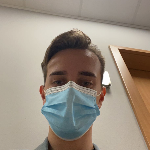

In [ ]:
test_sample = image.load_img('/content/drive/MyDrive/test_data/1.JPG')
test_sample = image.smart_resize(test_sample, (150, 150))
print("Input size: ", test_sample.shape)

test_img = image.img_to_array(test_sample)
test_img = np.expand_dims(test_img, 0)

img = image.array_to_img(test_sample)
img

In [ ]:
prediction = model.predict(test_img) > 0.5
pred = prediction[0][0].astype('int8')
if pred == 0:
  print("With mask")
else:
  print("Without mask")

1/1 [==============================] - 0s 28ms/step
With mask


Input size:  (150, 150, 3)


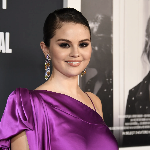

In [ ]:
test_sample = image.load_img('/content/drive/MyDrive/test_data/2.png')
test_sample = image.smart_resize(test_sample, (150, 150))
print("Input size: ", test_sample.shape)

test_img = image.img_to_array(test_sample)
test_img = np.expand_dims(test_img, 0)

img = image.array_to_img(test_sample)
img

In [ ]:
prediction = model.predict(test_img) > 0.5
pred = prediction[0][0].astype('int8')
if pred == 0:
  print("With mask")
else:
  print("Without mask")

1/1 [==============================] - 0s 48ms/step
Without mask


In [10]:
# from tensorflow.keras.models import load_model

# model = load_model("/content/drive/MyDrive/models_facemasks/my_model.h5")
# transfer_model = load_model("/content/drive/MyDrive/models_facemasks/transfer_model.h5")

In [12]:
test_directory = "/content/drive/MyDrive/test_data"
test_generator = ImageDataGenerator(
    rescale=1./255.
)
test_dataset = test_generator.flow_from_directory(
    directory=test_directory,
    target_size=(150, 150),
    batch_size=1,
    shuffle=False,
    class_mode="binary"
)

Found 56 images belonging to 2 classes.


In [32]:
y_prob_model = model.predict_generator(test_dataset, test_dataset.samples)
y_prob_transfer_model = transfer_model.predict_generator(test_dataset, test_dataset.samples)

y_prob_model = y_prob_model.ravel()
y_prob_transfer_model = y_prob_transfer_model.ravel()

y_true_classes = test_dataset.classes

<ipython-input-32-c0e76ef5bb68>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob_model = model.predict_generator(test_dataset, test_dataset.samples)
<ipython-input-32-c0e76ef5bb68>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob_transfer_model = transfer_model.predict_generator(test_dataset, test_dataset.samples)


In [33]:
data = {
    "y_prob_model" : y_prob_model,
    "y_prob_transfer_model" : y_prob_transfer_model,
    "y_true" : y_true_classes
}
df = pd.DataFrame(data)
df.head()

,y_prob_model,y_prob_transfer_model,y_true
0,0.093320,8.910909e-07,0
1,0.435000,3.760562e-03,0
2,0.043003,6.666032e-01,0
3,0.966984,3.978931e-03,0
4,0.504969,3.813144e-01,0


In [34]:
df["y_pred_model"] = df["y_prob_model"].apply(lambda x: 1 if x > 0.5 else 0)
df["y_pred_transfer_model"] = df["y_prob_transfer_model"].apply(lambda x: 1 if x > 0.5 else 0)
df.head()

,y_prob_model,y_prob_transfer_model,y_true,y_pred_model,y_pred_transfer_model
0,0.093320,8.910909e-07,0,0,0
1,0.435000,3.760562e-03,0,0,0
2,0.043003,6.666032e-01,0,0,1
3,0.966984,3.978931e-03,0,1,0
4,0.504969,3.813144e-01,0,1,0


In [42]:
from sklearn.metrics import classification_report, confusion_matrix

cm_model = confusion_matrix(df['y_true'].values, df['y_pred_model'].values)
fig = px.imshow(
    cm_model,
    x=["True with mask", "True without mask"],
    y=["Pred with mask", "Pred without mask"],
    text_auto=True,
    title="Model"
)
fig.update_xaxes(side="top")
fig.show()

In [44]:
cm_transfer_model = confusion_matrix(df['y_true'].values, df['y_pred_transfer_model'].values)
fig = px.imshow(
    cm_transfer_model,
    x=["True with mask", "True without mask"],
    y=["Pred with mask", "Pred without mask"],
    text_auto=True,
    title="Transfer Model"
)
fig.update_xaxes(side="top")
fig.show()

In [52]:
print("Classification report for model\n")
print(classification_report(df['y_true'].values, df['y_pred_model'].values))

Classification report for model

              precision    recall  f1-score   support

           0       0.87      0.38      0.53        34
           1       0.49      0.91      0.63        22

    accuracy                           0.59        56
   macro avg       0.68      0.65      0.58        56
weighted avg       0.72      0.59      0.57        56



In [53]:
print("Classification report for transfer model\n")
print(classification_report(df['y_true'].values, df['y_pred_transfer_model'].values))

Classification report for transfer model

              precision    recall  f1-score   support

           0       0.91      0.85      0.88        34
           1       0.79      0.86      0.83        22

    accuracy                           0.86        56
   macro avg       0.85      0.86      0.85        56
weighted avg       0.86      0.86      0.86        56



As we can see, model based on pre trained VGG16 architecture performs better. The main reason why the first model achieved worse metrics than the second one is the number of pictures in training dataset (around 300 images). As a further steps we can "unfreeze" a few last layers of the VGG16 model. It will adapt the model to our problem.

##Exploring bad predictions

In [56]:
df.index = test_dataset.filenames
df.head()

,y_prob_model,y_prob_transfer_model,y_true,y_pred_model,y_pred_transfer_model
with_mask/1.JPG,0.093320,8.910909e-07,0,0,0
with_mask/picFam01.jpeg,0.435000,3.760562e-03,0,0,0
with_mask/picFam02.jpeg,0.043003,6.666032e-01,0,0,1
with_mask/picFam03.jpeg,0.966984,3.978931e-03,0,1,0
with_mask/picFam04.jpeg,0.504969,3.813144e-01,0,1,0


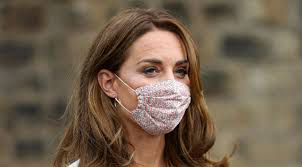

In [71]:
#@title Bad predictions - Model
indexes = df[df['y_true'] != df['y_pred_model']].index
idx = 0 #@param {type:'slider', min:0, max:22}
photo_dir = indexes[idx]
directory = os.path.join(test_directory, photo_dir)
img = image.load_img(directory)
img

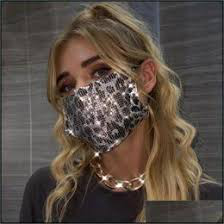

In [78]:
#@title Bad predictions - Transfer Model (VGG16)
indexes = df[df['y_true'] != df['y_pred_transfer_model']].index
idx = 3 #@param {type:'slider', min:0, max:7}
photo_dir = indexes[idx]
directory = os.path.join(test_directory, photo_dir)
img = image.load_img(directory)
img